## Yolov8 All views training

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install albumentations opencv-python

import os
import cv2
import glob
import albumentations as A
from collections import Counter

# ---------------------------
# Config
# ---------------------------
IMAGE_DIR = "/content/drive/MyDrive/For thesis/Defect Detection/allviews/allsides.v1i.yolov8/train/images"
LABEL_DIR = "/content/drive/MyDrive/For thesis/Defect Detection/allviews/allsides.v1i.yolov8/train/labels"
OUTPUT_IMG_DIR = "/content/drive/MyDrive/For thesis/Defect Detection/allviews/Dataset/train_aug/images"
OUTPUT_LAB_DIR = "/content/drive/MyDrive/For thesis/Defect Detection/allviews/Dataset/train_aug/labels"

os.makedirs(OUTPUT_IMG_DIR, exist_ok=True)
os.makedirs(OUTPUT_LAB_DIR, exist_ok=True)

# Fixed rotation angles
ROTATION_ANGLES = list(range(-15, 20, 5))  # [-15, -10, -5, 0, 5, 10, 15]

# ---------------------------
# Albumentations general pipeline (without rotation)
# ---------------------------
general_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.3),
    A.RandomBrightnessContrast(p=0.5),
    A.HueSaturationValue(p=0.3),
    A.GaussNoise(var_limit=(10.0, 50.0), p=0.3),
    A.MotionBlur(blur_limit=3, p=0.3),
    A.RandomGamma(p=0.3),
],
    bbox_params=A.BboxParams(
        format="yolo",
        label_fields=["class_labels"],
        min_visibility=0.1
    )
)

# ---------------------------
# Helper: Load YOLO labels (keep only class 0 = Defect)
# ---------------------------
def load_yolo_labels(label_path, keep_classes=[0]):
    boxes, classes = [], []
    if os.path.exists(label_path):
        with open(label_path, "r") as f:
            for line in f.readlines():
                parts = line.strip().split()
                if len(parts) == 5:
                    cls, x, y, w, h = parts
                    cls = int(float(cls))  # handles "0" or "0.0"
                    if cls in keep_classes:
                        boxes.append([float(x), float(y), float(w), float(h)])
                        classes.append(cls)
    return boxes, classes

# ---------------------------
# Augmentation Loop
# ---------------------------
image_paths = []
for ext in ["*.jpg", "*.png", "*.jpeg"]:
    image_paths.extend(glob.glob(os.path.join(IMAGE_DIR, ext)))

orig_class_counts = Counter()
aug_class_counts = Counter()

for img_path in image_paths:
    img = cv2.imread(img_path)
    if img is None:
        print("⚠️ Skipping unreadable image:", img_path)
        continue

    base = os.path.splitext(os.path.basename(img_path))[0]
    label_path = os.path.join(LABEL_DIR, base + ".txt")

    boxes, classes = load_yolo_labels(label_path, keep_classes=[0])

    # ---------------- CASE 1: BACKGROUND IMAGE (no defects) ----------------
    if len(boxes) == 0:
        # Save original
        orig_img_out = os.path.join(OUTPUT_IMG_DIR, f"{base}_orig.jpg")
        cv2.imwrite(orig_img_out, img, [cv2.IMWRITE_JPEG_QUALITY, 100])
        orig_lab_out = os.path.join(OUTPUT_LAB_DIR, f"{base}_orig.txt")
        open(orig_lab_out, "w").close()

        # Rotations
        for angle in ROTATION_ANGLES:
            rot_transform = A.Rotate(limit=(angle, angle), border_mode=cv2.BORDER_CONSTANT, value=0, p=1.0)
            rot_img = rot_transform(image=img)["image"]

            out_img_path = os.path.join(OUTPUT_IMG_DIR, f"{base}_rot{angle}.jpg")
            cv2.imwrite(out_img_path, rot_img, [cv2.IMWRITE_JPEG_QUALITY, 100])

            out_lab_path = os.path.join(OUTPUT_LAB_DIR, f"{base}_rot{angle}.txt")
            open(out_lab_path, "w").close()

        # General augmentations
        for i in range(2):
            aug_img = general_transform(image=img, bboxes=[], class_labels=[])["image"]
            out_img_path = os.path.join(OUTPUT_IMG_DIR, f"{base}_aug{i}.jpg")
            cv2.imwrite(out_img_path, aug_img, [cv2.IMWRITE_JPEG_QUALITY, 100])
            out_lab_path = os.path.join(OUTPUT_LAB_DIR, f"{base}_aug{i}.txt")
            open(out_lab_path, "w").close()

        continue  # move to next image

    # ---------------- CASE 2: DEFECT IMAGE ----------------
    orig_class_counts.update(classes)

    # Save original
    orig_img_out = os.path.join(OUTPUT_IMG_DIR, f"{base}_orig.jpg")
    cv2.imwrite(orig_img_out, img, [cv2.IMWRITE_JPEG_QUALITY, 100])
    orig_lab_out = os.path.join(OUTPUT_LAB_DIR, f"{base}_orig.txt")
    with open(orig_lab_out, "w") as f:
        for cls, bbox in zip(classes, boxes):
            x, y, w_, h_ = bbox
            f.write(f"{cls} {x:.6f} {y:.6f} {w_:.6f} {h_:.6f}\n")
    aug_class_counts.update(classes)

    # Rotations
    for angle in ROTATION_ANGLES:
        rot_transform = A.Compose([
            A.Rotate(limit=(angle, angle), border_mode=cv2.BORDER_CONSTANT, value=0, p=1.0),
        ], bbox_params=A.BboxParams(
            format="yolo",
            label_fields=["class_labels"],
            min_visibility=0.1
        ))

        rotated = rot_transform(image=img, bboxes=boxes, class_labels=classes)
        rot_img, rot_boxes, rot_classes = rotated["image"], rotated["bboxes"], rotated["class_labels"]

        out_img_path = os.path.join(OUTPUT_IMG_DIR, f"{base}_rot{angle}.jpg")
        cv2.imwrite(out_img_path, rot_img, [cv2.IMWRITE_JPEG_QUALITY, 100])
        out_lab_path = os.path.join(OUTPUT_LAB_DIR, f"{base}_rot{angle}.txt")
        with open(out_lab_path, "w") as f:
            for cls, bbox in zip(rot_classes, rot_boxes):
                x, y, w_, h_ = bbox
                x, y, w_, h_ = [min(max(v, 0), 1) for v in (x, y, w_, h_)]
                f.write(f"{cls} {x:.6f} {y:.6f} {w_:.6f} {h_:.6f}\n")
        aug_class_counts.update(rot_classes)

    # General augmentations
    for i in range(2):
        augmented = general_transform(image=img, bboxes=boxes, class_labels=classes)
        aug_img, aug_boxes, aug_classes = augmented["image"], augmented["bboxes"], augmented["class_labels"]

        out_img_path = os.path.join(OUTPUT_IMG_DIR, f"{base}_aug{i}.jpg")
        cv2.imwrite(out_img_path, aug_img, [cv2.IMWRITE_JPEG_QUALITY, 100])
        out_lab_path = os.path.join(OUTPUT_LAB_DIR, f"{base}_aug{i}.txt")
        with open(out_lab_path, "w") as f:
            for cls, bbox in zip(aug_classes, aug_boxes):
                x, y, w_, h_ = bbox
                x, y, w_, h_ = [min(max(v, 0), 1) for v in (x, y, w_, h_)]
                f.write(f"{cls} {x:.6f} {y:.6f} {w_:.6f} {h_:.6f}\n")
        aug_class_counts.update(aug_classes)

# ---------------------------
# Summary
# ---------------------------
print("\n✅ Augmentation complete!")
print("Augmented images saved in:", OUTPUT_IMG_DIR)
print("\n📊 Class Distribution:")
print("Original:", dict(orig_class_counts))
print("After Augmentation (with background):", dict(orig_class_counts + aug_class_counts))


/tmp/ipython-input-2101838834.py:31: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(10.0, 50.0), p=0.3),
/tmp/ipython-input-2101838834.py:90: UserWarning: Argument(s) 'value' are not valid for transform Rotate
  rot_transform = A.Rotate(limit=(angle, angle), border_mode=cv2.BORDER_CONSTANT, value=0, p=1.0)
/tmp/ipython-input-2101838834.py:125: UserWarning: Argument(s) 'value' are not valid for transform Rotate
  A.Rotate(limit=(angle, angle), border_mode=cv2.BORDER_CONSTANT, value=0, p=1.0),



✅ Augmentation complete!
Augmented images saved in: /content/drive/MyDrive/For thesis/Defect Detection/allviews/Dataset/train_aug/images

📊 Class Distribution:
Original: {0: 2205}
After Augmentation (with background): {0: 24253}


In [ ]:
import os
import random
import shutil
from pathlib import Path
import yaml

# ===== CONFIG =====
dataset_root = "/content/drive/MyDrive/For thesis/Defect Detection/allviews/Dataset/train_aug"
output_root = "/content/drive/MyDrive/For thesis/Defect Detection/allviews/allviews/datasetsplit_dataset"

train_ratio, val_ratio, test_ratio = 0.7, 0.2, 0.1
yaml_template = "/content/drive/MyDrive/For thesis/Defect Detection/allviews/allsides.v1i.yolov8/data.yaml"

# ===== MAKE OUTPUT DIRS =====
for split in ["train", "valid", "test"]:
    for sub in ["images", "labels"]:
        Path(f"{output_root}/{split}/{sub}").mkdir(parents=True, exist_ok=True)

# ===== COLLECT FILES =====
images_dir = Path(dataset_root) / "images"
labels_dir = Path(dataset_root) / "labels"
all_images = [f for f in images_dir.glob("*.jpg")] + [f for f in images_dir.glob("*.png")]

print(f"📂 Found {len(all_images)} images")

# ===== SHUFFLE & SPLIT =====
random.shuffle(all_images)
n_total = len(all_images)
n_train = int(train_ratio * n_total)
n_val = int(val_ratio * n_total)

train_files = all_images[:n_train]
val_files = all_images[n_train:n_train+n_val]
test_files = all_images[n_train+n_val:]

splits = {"train": train_files, "valid": val_files, "test": test_files}

# ===== COPY FILES =====
for split, files in splits.items():
    for img_path in files:
        lbl_path = labels_dir / (img_path.stem + ".txt")
        # copy image
        shutil.copy(img_path, f"{output_root}/{split}/images/{img_path.name}")
        # copy label
        if lbl_path.exists():
            shutil.copy(lbl_path, f"{output_root}/{split}/labels/{lbl_path.name}")

print("✅ Dataset split into train/valid/test and copied to", output_root)

# ===== UPDATE YAML =====
with open(yaml_template, "r") as f:
    data = yaml.safe_load(f)

data["train"] = str(Path(output_root) / "train/images")
data["val"]   = str(Path(output_root) / "valid/images")
data["test"]  = str(Path(output_root) / "test/images")

yaml_out = Path(output_root) / "data.yaml"
with open(yaml_out, "w") as f:
    yaml.safe_dump(data, f)

print("✅ New YAML saved at:", yaml_out)


📂 Found 8880 images
✅ Dataset split into train/valid/test and copied to /content/drive/MyDrive/For thesis/Defect Detection/allviews/allviews/datasetsplit_dataset
✅ New YAML saved at: /content/drive/MyDrive/For thesis/Defect Detection/allviews/allviews/datasetsplit_dataset/data.yaml


In [ ]:
# Install YOLO if not already
!pip install ultralytics

from ultralytics import YOLO
import os

# ---------------------------
# Config
# ---------------------------
DATA_YAML = "/content/drive/MyDrive/For thesis/Defect Detection/allviews/allviews/datasetsplit_dataset/data.yaml"
# 👆 this is the NEW yaml created from your Roboflow template with updated train/val/test paths

MODEL = "yolov8s.pt"          # pretrained backbone
EPOCHS = 100                  # total epochs
BATCH = 8                     # adjust if you hit OOM
IMGSZ = 1920                  # high res for small defects
PATIENCE = 15                 # early stopping patience

SAVE_DIR = "/content/drive/MyDrive/For thesis/Defect Detection/allviews"

# ---------------------------
# Train (with resume support)
# ---------------------------

# Path to last run checkpoint (Ultralytics auto-saves best + last.pt)
last_ckpt = os.path.join(SAVE_DIR, "train/weights/last.pt")

if os.path.exists(last_ckpt):
    print("🔄 Resuming training from last checkpoint...")
    model = YOLO(last_ckpt)
    model.train(
        resume=True
    )
else:
    print("🚀 Starting fresh training with YOLOv8s...")
    model = YOLO(MODEL)  # load pretrained YOLOv8s backbone
    model.train(
        data=DATA_YAML,
        epochs=EPOCHS,
        batch=BATCH,
        imgsz=IMGSZ,
        patience=PATIENCE,
        project=SAVE_DIR,
        name="train",
        exist_ok=True,
        amp=True  # mixed precision
    )


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 72.1 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
🚀 Starting fresh training with YOLOv8s...
Ultralytics 8.3.204 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (NVIDIA L4, 22693MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/For thesis/Defect Detection/allviews/allviews/datasetsplit_dataset/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=

In [ ]:
# Install YOLO if not already
!pip install ultralytics
from ultralytics import YOLO

# Path to your last checkpoint
last_ckpt = "/content/drive/MyDrive/For thesis/Defect Detection/allviews/train/weights/last.pt"

# Load the model and resume training
model = YOLO(last_ckpt)
model.train(resume=True)


Ultralytics 8.3.204 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (NVIDIA L4, 22693MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/For thesis/Defect Detection/allviews/allviews/datasetsplit_dataset/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=1920, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=/content/drive/MyDrive/For thesis/Defect Detection/allviews/train/weights/last.pt, momentum=0.937, mosaic=1.0, multi_scale=False, 

In [ ]:
# Install YOLO if not already
!pip install ultralytics
from ultralytics import YOLO

# Path to your last checkpoint
last_ckpt = "/content/drive/MyDrive/For thesis/Defect Detection/allviews/train/weights/last.pt"

# Load the model and resume training
model = YOLO(last_ckpt)
model.train(resume=True)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 64.2 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Ultralytics 8.3.205 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (NVIDIA L4, 22693MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/For thesis/Defect Detection/allviews/allviews/datasetsplit_dataset/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=True, fliplr=0.

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7eca598d7740>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 


image 1/1 /content/drive/MyDrive/Thesis/dataset/275ML_Bottle/Top view/good/enhanced_Line1Cam3PassImage811_429_12398.png: 1920x1920 4 Defects, 8072.5ms
Speed: 39.4ms preprocess, 8072.5ms inference, 3.0ms postprocess per image at shape (1, 3, 1920, 1920)
Results saved to /content/runs/detect/predict20


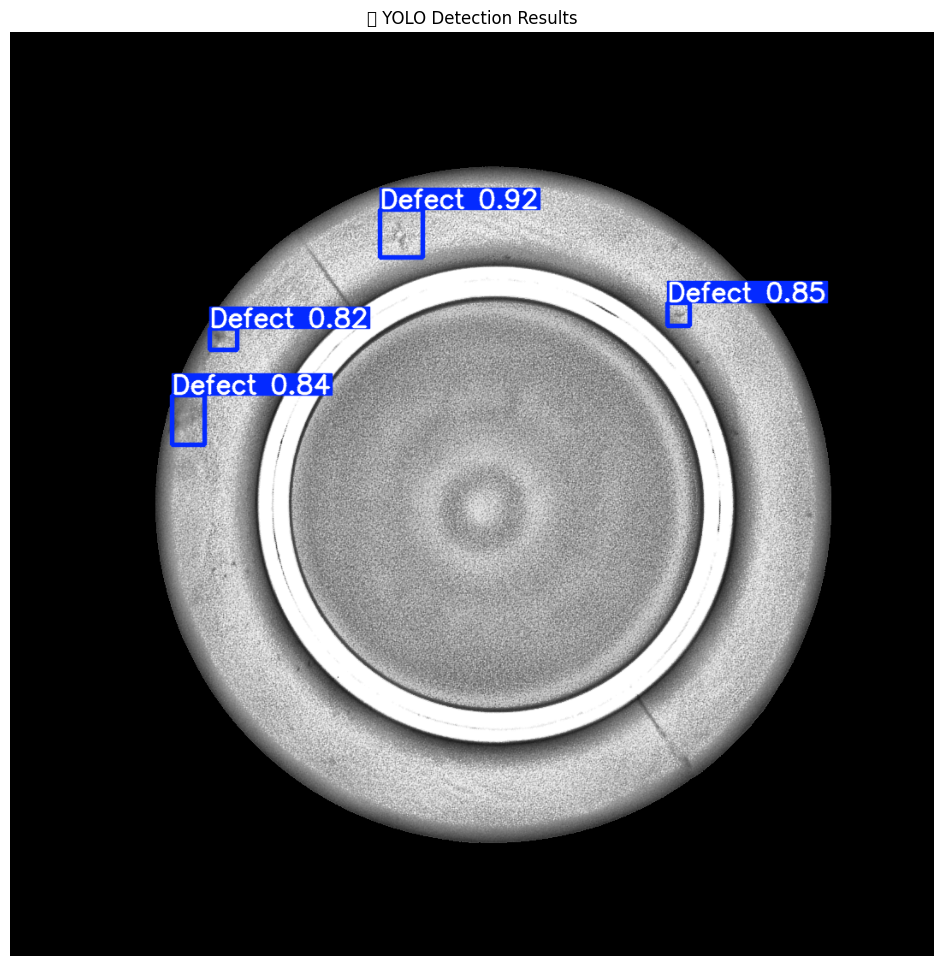

Detected class Defect with 0.92 confidence at [432.7353210449219, 207.12403869628906, 482.2829895019531, 263.6816711425781]
Detected class Defect with 0.85 confidence at [768.4678344726562, 316.3165588378906, 794.7662353515625, 343.4198303222656]
Detected class Defect with 0.84 confidence at [189.42001342773438, 424.6341247558594, 227.9126739501953, 482.66094970703125]
Detected class Defect with 0.82 confidence at [233.96778869628906, 346.7000732421875, 265.6953430175781, 371.7388916015625]


In [ ]:
# ============================
# 📦 INSTALL + IMPORT
# ============================
!pip install ultralytics --quiet

from ultralytics import YOLO
import cv2
from matplotlib import pyplot as plt

# ============================
# ⚙️ CONFIGURATION
# ============================
MODEL_PATH = "/content/drive/MyDrive/For thesis/Defect Detection/allviews/train/weights/best.pt"
IMAGE_PATH = "/content/drive/MyDrive/Thesis/dataset/275ML_Bottle/Top view/good/enhanced_Line1Cam3PassImage811_429_12398.png"
CONF_THRESHOLD = 0.2  # confidence cutoff; increase (0.5–0.7) to reduce false positives

# ============================
# 🚀 LOAD MODEL AND RUN
# ============================
model = YOLO(MODEL_PATH)
results = model.predict(source=IMAGE_PATH, conf=CONF_THRESHOLD, save=True, show=False)

# The prediction image with boxes is saved automatically in runs/predict/
# You can also visualize inline:
result_img = results[0].plot()  # draw boxes on a numpy array

plt.figure(figsize=(12, 12))
plt.imshow(cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title("🔍 YOLO Detection Results")
plt.show()

# ============================
# 🧾 OPTIONAL: PRINT DETECTION SUMMARY
# ============================
for box in results[0].boxes:
    cls = int(box.cls[0])
    conf = float(box.conf[0])
    xyxy = box.xyxy[0].tolist()
    print(f"Detected class {model.names[cls]} with {conf:.2f} confidence at {xyxy}")
